# Densely Connected Networks (DenseNet)



In [1]:
import torch
from torch import nn
from d2l import torch as d2l

Dense Blocks

In [3]:
def conv_block(num_channels):
    return nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size=3, padding=1))

class DenseBlock(nn.Module):
    def __init__(self, num_convs, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(num_channels))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            X = torch.cat((X, Y), dim=1)
        return X

Define a `DenseBlock` instance

In [4]:
blk = DenseBlock(2, 10)
X = torch.randn(4, 3, 8, 8)
Y = blk(X)
Y.shape

torch.Size([4, 23, 8, 8])

Transition Layers

In [5]:
def transition_block(num_channels):
    return nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2))

Apply a transition layer

In [6]:
blk = transition_block(10)
blk(Y).shape

torch.Size([4, 10, 4, 4])

DenseNet Model

In [8]:
class DenseNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

@d2l.add_to_class(DenseNet)
def __init__(self, num_channels=64, growth_rate=32, arch=(4, 4, 4, 4),
             lr=0.1, num_classes=10):
    super(DenseNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1())
    for i, num_convs in enumerate(arch):
        self.net.add_module(f'dense_blk{i+1}', DenseBlock(num_convs,
                                                          growth_rate))
        num_channels += num_convs * growth_rate
        if i != len(arch) - 1:
            num_channels //= 2
            self.net.add_module(f'tran_blk{i+1}', transition_block(
                num_channels))
    self.net.add_module('last', nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    self.net.apply(d2l.init_cnn)

Training

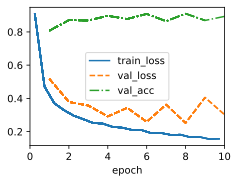

In [9]:
model = DenseNet(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
trainer.fit(model, data)